In [1]:
import getpass
import os
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

/opt/miniconda3/envs/DL_ee559/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Implicit hate speech detection

Get help from this [kaggle page](https://www.kaggle.com/code/yousefadham/working-hatebert)

# Load the data

In [2]:
#PATH_DATA = "data/implicit-hate-corpus/"
#PATH_INPUT_POSTS = "implicit_hate_v1_SAP_posts.tsv"
#PATH_HATE_LABEL = "implicit_hate_v1_stg1.tsv"
#PATH_CATEGORY_LABEL = "implicit_hate_v1_stg2.tsv"

#input = pd.read_csv(PATH_DATA + PATH_INPUT_POSTS, sep = '\t')
#hate_labels = pd.read_csv(PATH_DATA + PATH_HATE_LABEL, sep = '\t')
#category_labels = pd.read_csv(PATH_DATA + PATH_CATEGORY_LABEL, sep = '\t')




PATH_DATA_STG1 = "data/implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv"

data = pd.read_csv(PATH_DATA_STG1, sep = '\t')
print(data)
num_labels = 3

                                                    post          class
0        " : jewish harvard professor noel ignatiev w...  implicit_hate
1       b.higher education is a part of european cult...       not_hate
2       has a problem with  " the whites " " and " " ...       not_hate
3       is yasir qadhi a hate preacher for calling ch...       not_hate
4       rt  " : how three million germans mass murder...       not_hate
...                                                  ...            ...
21475  Seeing prostitutes is morally wrong, but being...  implicit_hate
21476  I wonder how many females I raped today I spen...  implicit_hate
21477  Having a criminal record is more attractive to...  implicit_hate
21478  Another advantage of being a female: getting b...  implicit_hate
21479  If men are so privileged and women have it so ...  implicit_hate

[21480 rows x 2 columns]


# Data Set  Distribution 

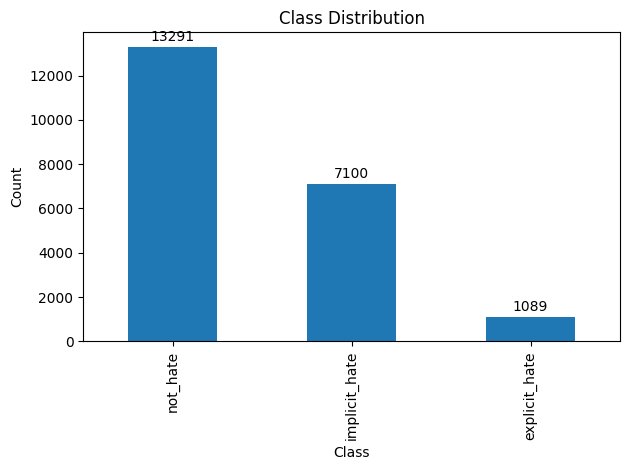

In [3]:

class_counts = data['class'].value_counts()

# Plot
ax = class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

for i, count in enumerate(class_counts):
    plt.text(i, count + max(class_counts)*0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# General Constant

In [4]:
#Set some general constant that will be used in the entire code
RANDOM_SEED = 42
MAX_LENGTH = 512 #max size of the tokenizer https://huggingface.co/GroNLP/hateBERT/commit/f56d507e4b6a64413aff29e541e1b2178ee79d67
EPOCHS = 4
BATCH_SIZE = 16

## Data preparation (labels and text extraction and remaping)

In [5]:
# Label mappings
id2label = {0: "not_hate", 1: "implicit_hate", 2: "explicit_hate"}
label2id = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}


# Load data text
texts = data['post'].values

# Convert the labels to numerical values
print("Labels before mapping: \n", data['class'].values[:11])
data['class'] = data['class'].map(label2id)
labels = data['class'].values
print("Labels after mapping:  ", labels[:11])

Labels before mapping: 
 ['implicit_hate' 'not_hate' 'not_hate' 'not_hate' 'not_hate' 'not_hate'
 'implicit_hate' 'not_hate' 'explicit_hate' 'explicit_hate' 'not_hate']
Labels after mapping:   [1 0 0 0 0 0 1 0 2 2 0]


# Load the Hate Bert model

We decide to use the Hate Bert model, a Bert model specially trained to detect hate. This model can be use from hugging face [plateforme](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html).

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    "GroNLP/hateBERT",
    num_labels=num_labels,
    id2label=id2label, 
    label2id=label2id,
    output_attentions=False,
    output_hidden_states=False
)

print(model.num_parameters())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


109484547


### Load the tokenizer

From hugging face plateforme, we can also load the tokenizer specially made for Hate Bert

In [7]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")

### DataLoader initialization & Data splitting

In [8]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return  {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
    
        
           

In [9]:
# Spliting data (80% train and 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=RANDOM_SEED
)

# TRAIN dataset
train_dataset = HateSpeechDataset(
    texts=train_texts,
    labels=train_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# TESTING dataset
test_dataset = HateSpeechDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)


# DATALOADER for training set
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# DATALOADER for testing set
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Train the model

We use the default training configuration from the kaggle page

In [10]:
optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device("cpu")

# Calculate class weights
"""
class_weights = torch.tensor([len(train_dataset) / (7 * 15294),  # toxic
                              len(train_dataset) / (7 * 1595),   # severe_toxic
                              len(train_dataset) / (7 * 8449),   # obscene
                              len(train_dataset) / (7 * 478),    # threat
                              len(train_dataset) / (7 * 7877),   # insult
                              len(train_dataset) / (7 * 1405),   # identity_hate
                              len(train_dataset) / (7 * 143346)  # normal
                             ]).to(device)

"""

# Class distribution from your dataset
class_counts = [13291, 7100, 1089]
total = sum(class_counts)

# Inverse frequency (optional: normalize)
class_weights = [total / c for c in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted BCEWithLogitsLoss
criterion = BCEWithLogitsLoss(weight=class_weights)


model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Scheduler 

In [11]:

num_training_steps = EPOCHS * len(train_dataset)
# feel free to experiment with different num_warmup_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=1, num_training_steps=num_training_steps
)

In [12]:
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []


progress_bar = tqdm(range(num_training_steps))

for epoch in range(EPOCHS):
    model.train()

    # Create a tqdm progress bar for the training data
    train_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{EPOCHS}', dynamic_ncols=True)

    for batch in train_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        _, labels_indices = labels.max(dim=1)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels_indices)
        
        
#                        # Extract predicted probabilities
#         predicted_probs = torch.sigmoid(outputs.logits)

#         # Print the predicted probabilities for the first example in the batch
#         print("Predicted Probabilities:", predicted_probs[0].detach().cpu().numpy())

        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the tqdm progress bar
        progress_bar.update(1)

    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Create a tqdm progress bar for the validation data
    val_iterator = tqdm(test_dataset, desc='Validation', dynamic_ncols=True)

    with torch.no_grad():
        for batch in val_iterator:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            _, labels_indices = labels.max(dim=1)
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels_indices)
            val_loss += outputs.loss.item()
            _, predicted_indices = outputs.logits.max(dim=1)
            correct_predictions += (predicted_indices == labels_indices).sum().item()
            total_samples += labels.size(0)

            # Update the tqdm progress bar
            val_iterator.set_postfix(val_loss=val_loss / len(val_iterator))
            
     # Calculate accuracy
    accuracy = correct_predictions / total_samples

    # Append values to lists
    train_losses.append(loss.item())
    val_losses.append(val_loss / len(test_dataset))
    val_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}/{EPOCHS}, Validation Loss: {val_loss / len(test_dataset)}, Accuracy: {accuracy}')
    

  0%|          | 0/68736 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'to'

In [ ]:
progress_bar = tqdm(range(num_training_steps))

# put the model in train mode
model.train()

# iterate over epochs
for epoch in range(num_epochs):
    # iterate over batches in training set
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        '''
        **kwargs is a common idiom to allow an arbitrary number of arguments to functions
        The **kwargs will give you all keyword arguments as a dictionary
        https://stackoverflow.com/questions/36901/what-does-double-star-asterisk-and-star-asterisk-do-for-parameters
        '''
        

        outputs = model(**batch)
        '''
        Note that Transformers models all have a default task-relevant loss function,
        so you don’t need to specify one unless you want to

        Get the loss form the outputs
        in this example, the outputs are instances of subclasses of ModelOutput
        https://huggingface.co/transformers/v4.3.0/main_classes/output.html
        Those are data structures containing all the information returned by
        the model, but that can also be used as tuples or dictionaries.

        The outputs object has a loss and logits attribute
        You can access each attribute as you would usually do,
        and if that attribute has not been returned by the model, you will get None.
        for instance, outputs.loss is the loss computed by the model
        '''

        ### BEGIN SOLUTION
        loss = outputs.loss
        ### END SOLUTION

        # do the backward pass
        ### BEGIN SOLUTION
        loss.backward()
        ### END SOLUTION

        # perform one step of the optimizer
        ### BEGIN SOLUTION
        optimizer.step()
        ### END SOLUTION

        # peform one step of the lr_scheduler, similar with the optimizer
        ### BEGIN SOLUTION
        lr_scheduler.step()
        ### END SOLUTION

        # zero the gradients, call zero_grad() on the optimizer
        ### BEGIN SOLUTION
        optimizer.zero_grad()
        ### END SOLUTION

        progress_bar.update(1)

In [ ]:
import evaluate

# define the metric you want to use to evaluate your model
metric = evaluate.load("accuracy")
progress_bar = tqdm(range(len(eval_dataloader)))

# put the model in eval mode
model_bert_l4.eval()
# iterate over batches of evaluation dataset
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        '''
        pass the batches to the model and get the outputs
        (hint: look at the training loop)
        outputs = ...
        '''
        ### BEGIN SOLUTION
        outputs = model_bert_l4(**batch)
        ### END SOLUTION

    
    '''
    get the logits from the outputs,
    similar as you did for the loss in the training loop
    logits = ...
    '''
    ### BEGIN SOLUTION
    logits = outputs.logits
    ### END SOLUTION

    # use argmax to get the predicted class
    predictions = torch.argmax(logits, dim=-1)
    
    '''
    metric.add_batch() adds a batch of predictions and references
    Metric.add_batch() by passing it your model predictions, and the references
    the model predictions should be evaluated against
    '''
    metric.add_batch(predictions=predictions, references=batch["labels"])
    progress_bar.update(1)
# calculate a metric by  calling metric.compute()
metric.compute()

